## <center> Quantifying Extragalactic Contamination in Dust Intensity Maps Generated Using PySM </center>

In [1]:
import pysm3
from pysm3 import units as u
import pandas as pd
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

#### Use PySM to Generate Dust Intensity Map

In [2]:
nside = 2048
freq = 353 * u.GHz
sky_model = pysm3.Sky(preset_strings=['d1'],nside=nside)
dust_i_map = sky_model.get_emission(freq)[0]

#### Generate Mask to Omit Between -30. and 30. Dec

In [3]:
npixels = 12 * nside ** 2
pixindx = np.arange(npixels)
l_pix, b_pix = hp.pix2ang(nside,pixindx,lonlat=True)
mask_pixels = pixindx[np.abs(b_pix) < 30.]
good_pixels = pixindx[np.abs(b_pix) > 30.]

#### Read in Galaxy Catalog

In [4]:
galaxy_data = pd.read_csv('Downloads/GLADE+_2048.csv')
galaxy_data = galaxy_data.loc[(galaxy_data.Z > 0) & (galaxy_data.Z < 3.1488)]
galaxy_data = galaxy_data.loc[(galaxy_data.Pix < mask_pixels[0]) | (galaxy_data.Pix > mask_pixels[-1])]
pixels = galaxy_data.Pix
z_bin_i = galaxy_data.Z_bin

#### Get Z-bins from Tomographer Binning

In [5]:
tomo_z_bin = pd.read_csv('Downloads/Tomographer_GLADE+.csv')['z']

#### Generate Galaxy Density Maps for Each Z-bin

In [6]:
z_maps = []
n_zbins = len(tomo_z_bin)
bins = np.arange(npixels + 1)

for i in range(len(tomo_z_bin)):
    pix_zbin_i = pixels[z_bin_i == i]
    n_gal_in_zbin_ppix, bin_edges = np.histogram(pix_zbin_i,bins=bins)
    z_maps.append(n_gal_in_zbin_ppix)

#### Generate Smoothed Maps

In [7]:
smooth_dim = hp.sphtfunc.smoothing(dust_i_map,fwhm=np.radians(1))
smooth_zm = [hp.sphtfunc.smoothing(x,fwhm=0.562) for x in z_maps]

#### Preprocess Data for Correlation

In [8]:
corr_red = np.subtract(dust_i_map[good_pixels].value,smooth_dim[good_pixels])

In [9]:
corr_bins = []
ones_arr = np.ones(len(good_pixels))

for i in range(n_zbins):
    exp_gal_count = np.subtract(smooth_zm[i][good_pixels],ones_arr)
    act_gal_count = z_maps[i][good_pixels]
    corr_bins.append(np.divide(act_gal_count,exp_gal_count))

#### Cross-correlate Data

In [10]:
corr_data = []
for i in range(n_zbins):
    corr_data.append(np.correlate(corr_red,corr_bins[i]))

#### Plot Results

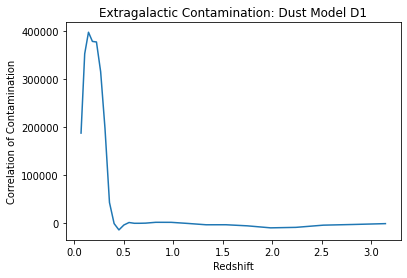

In [11]:
plt.plot(tomo_z_bin,corr_data)
plt.title('Extragalactic Contamination: Dust Model D1')
plt.xlabel('Redshift')
plt.ylabel('Correlation of Contamination')
plt.show()